# Test Lightning Refactor

In [94]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import yaml
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Add src to path
sys.path.append('../src')
sys.path.append('../scripts')

# Imports
from models.submodels.euclidnet import EuclidNet_SO3, EuclidNet_SO2
from models.submodels.interaction_gnn import InteractionGNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load config file
with open('debug_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [51]:
def Ry(theta):
    if isinstance(theta, float) or isinstance(theta, int) or isinstance(theta, np.float32):
        theta = torch.tensor(theta)
    return torch.tensor([
        [torch.cos(theta), 0., torch.sin(theta)],
        [0., 1., 0.],
        [-torch.sin(theta), 0., torch.cos(theta)]
    ])

def Rz(theta):
    if isinstance(theta, float) or isinstance(theta, int) or isinstance(theta, np.float32):
        theta = torch.tensor(theta)
    return torch.tensor([
        [torch.cos(theta), torch.sin(theta), 0.],
        [-torch.sin(theta), torch.cos(theta), 0.],
        [0., 0., 1.]
    ])

## Roadmap

1. Load in some data
2. Run data through model
3. Transform data
4. Run transformed data through model
5. Compare outputs

## SO(3) Equivariance tests

In [101]:
model = EuclidNet_SO3(config)

In [102]:
model.setup(stage="fit")

Setting up dataset


In [103]:
sample = model.trainset[0]

In [104]:
sample

Data(x=[3366, 3], edge_index=[2, 46426], edge_attr=[46426, 4], y=[46426], pid=[3366], pt=[3366], eta=[3366], num_nodes=3366)

In [105]:
with torch.no_grad():
    Ry_errors = []
    Rz_errors = []
    out = model(sample.x, sample.edge_index)

    param_space = np.linspace(-np.pi, np.pi, 100, dtype=np.float32)
    for theta in tqdm(param_space):
        transformed_sample = (Ry(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Ry_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

        transformed_sample = (Rz(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Rz_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


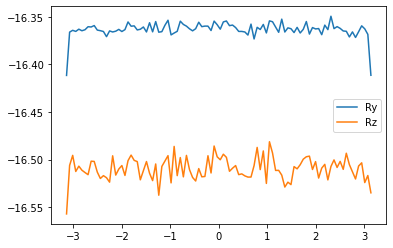

In [106]:
# Plot in log space
plt.plot(param_space, np.log(Ry_errors), label="Ry")
plt.plot(param_space, np.log(Rz_errors), label="Rz")
plt.legend()
plt.show()

## SO(2) Equivariance tests

In [87]:
model = EuclidNet_SO2(config)

In [88]:
model.setup(stage="fit")

Setting up dataset


In [89]:
sample = model.trainset[0]

In [90]:
sample

Data(x=[3357, 3], edge_index=[2, 49074], edge_attr=[49074, 4], y=[49074], pid=[3357], pt=[3357], eta=[3357], num_nodes=3357)

In [91]:
with torch.no_grad():
    Ry_errors = []
    Rz_errors = []
    out = model(sample.x, sample.edge_index)

    param_space = np.linspace(-np.pi, np.pi, 100, dtype=np.float32)
    for theta in tqdm(param_space):
        transformed_sample = (Ry(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Ry_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

        transformed_sample = (Rz(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Rz_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


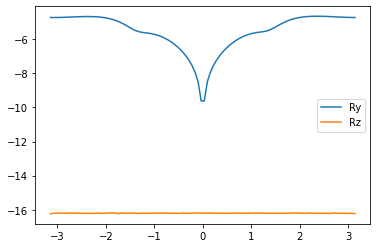

In [93]:
# Plot in log space
plt.plot(param_space, np.log(Ry_errors), label="Ry")
plt.plot(param_space, np.log(Rz_errors), label="Rz")
plt.legend()
plt.show()

## SO(3) Equivariance tests

In [95]:
model = InteractionGNN(config)

In [96]:
model.setup(stage="fit")

Setting up dataset


In [97]:
sample = model.trainset[0]

In [98]:
sample

Data(x=[2370, 3], edge_index=[2, 26090], edge_attr=[26090, 4], y=[26090], pid=[2370], pt=[2370], eta=[2370], num_nodes=2370)

In [99]:
with torch.no_grad():
    Ry_errors = []
    Rz_errors = []
    out = model(sample.x, sample.edge_index)

    param_space = np.linspace(-np.pi, np.pi, 100, dtype=np.float32)
    for theta in tqdm(param_space):
        transformed_sample = (Ry(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Ry_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

        transformed_sample = (Rz(theta) @ sample.x.T).T
        out2 = model(transformed_sample, sample.edge_index)
        Rz_errors.append((out - out2).abs().sum() / sample.edge_index.shape[1])

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


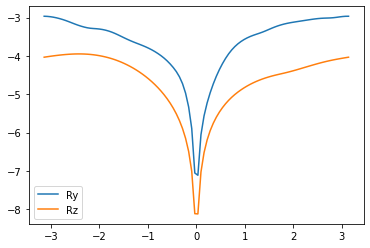

In [100]:
# Plot in log space
plt.plot(param_space, np.log(Ry_errors), label="Ry")
plt.plot(param_space, np.log(Rz_errors), label="Rz")
plt.legend()
plt.show()